# Point reconstruction in NEXT-NEW

In this notebook we read in the prepared data, construct and train the DNN, and then evaluate its performance for reconstruction of point-like events in NEXT-NEW.

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy  as np
import random as rd
import tables as tb
import h5py
import tensorflow as tf

from matplotlib.patches         import Ellipse
from __future__  import print_function
from scipy.stats import threshold

# Keras imports
import keras.backend.tensorflow_backend as K
from keras.models               import Model, load_model, Sequential
from keras.layers               import Input, Dense, MaxPooling3D, AveragePooling3D, Convolution3D, Activation, Dropout, merge
from keras.layers.normalization import BatchNormalization
from keras.optimizers           import SGD, Adam, Nadam         
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core          import Flatten
from keras                      import callbacks
from keras.regularizers         import l2

# Variable definitions
Here we define key variables to be used throughout the notebook.  Note that we will read the data from a directory `data_location/run_name`, and it is stored in multiple files:
- The training data will consist of the events stored in files from `train_fstart` to `train_fend`
- The test data will consist of the events stored in files from `test_fstart` to `test_fend`

In [2]:
# data dimensions
xdim = 48
ydim = 48
zdim = 1

# data location and training/test file numbers
data_fname = "/Users/jrenner/IFIC/jerenner/next-deeplearning-analysis/data/dnn_kr_100k.h5"

## Function definitions

### Data input functions

In [3]:
# define the function to read the data from multiple files
def read_data(dat_file):
    """Reads all events from the files with the specified file numbers."""
    
    # get the maps and the labels from the data file
    indata = tb.open_file(dat_file, 'r')
    sum_maps = np.reshape(indata.root.maps,(len(indata.root.maps), 48, 48))
    labels = np.array(indata.root.coords,dtype=np.float32)
    indata.close()

    # reshape the maps to add the extra channel dimension and the labels to fit in the interval [0,1]
    x_ = np.reshape(sum_maps, (len(sum_maps), 48, 48, 1))
    y_ = labels[:,:2]/400. + 0.5
    
    print("Finished reading data.")
    return x_,y_

### Neural network models
These functions should define and return a Keras model object.

In [15]:
# define a fully-connected neural network with 64 hidden neurons and 1 readout neuron
def model_FC(inputs):

    model = Sequential()
    model.add(Flatten(input_shape=(48,48,1)))
    model.add(Dense(output_dim=1024,activation='relu')) 
    model.add(Dense(output_dim=512,  activation='relu'))
    model.add(Dense(output_dim=256,  activation='relu'))
    model.add(Dense(output_dim=128, activation='relu'))
    #model.add(Dense(output_dim=64, activation='relu'))
    model.add(Dense(output_dim=2,    activation='relu'))

    model.compile(loss='mse',
                  optimizer=Nadam(lr=0.001, beta_1=0.9, beta_2=0.999,
                                  epsilon=1e-08, schedule_decay=0.01),
                                  metrics=['accuracy']) 
    return model

In [16]:
# plot a 48x48 SiPM map
# -- carried over from NEW_kr_diff_mc_train.ipynb
def NEW_SiPM_map_plot(xarr, normalize=True):
    """
    Plots a SiPM map in the NEW Geometry
    xarr is a NEW sipm map, yarr the pair of coordinates the map corresponds to
    """
    if normalize:
        probs = (xarr - np.min(xarr))
        probs /= np.max(probs)
    else: 
        probs = xarr

    # set up the figure
    fig = plt.figure();
    ax1 = fig.add_subplot(111);
    fig.set_figheight(5.0)
    fig.set_figwidth(5.0)
    ax1.axis([-250, 250, -250, 250]);

    for i in range(48):
        for j in range(48):
            r = Ellipse(xy=(i * 10 - 235, j * 10 - 235), width=2., height=2.);
            r.set_facecolor('0');
            r.set_alpha(probs[i, j]);
            ax1.add_artist(r);
        
    plt.xlabel("x (mm)");
    plt.ylabel("y (mm)");

## Load in the data

In [17]:
# read in the training data
x_train, y_train = read_data(data_fname)

Finished reading data.


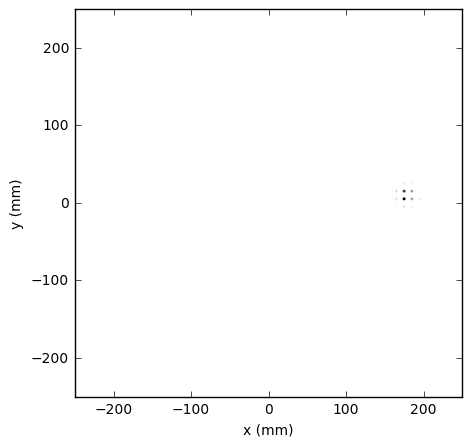

In [18]:
# plot one slice of one event with corresponding true point
NEW_SiPM_map_plot(x_train[0,:,:,0])

## Define and train the DNN

In [19]:
# set load_model to true and specify the file to load in a previously defined/trained model
load_model = False
mfile = 'models/conv3d_classifier.h5'

if(load_model):
    model = load_model(mfile)
else:
    
    # otherwise define the model
    inputs = Input(shape=(xdim, ydim, zdim, 1))
    model = model_FC(inputs)
    
    # define callbacks (actions to be taken after each epoch of training)
    file_lbl = "{epoch:02d}-{loss:.4f}"
    filepath="weights-{0}.h5".format(file_lbl)
    checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    lcallbacks = [checkpoint]            
    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2360320   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 258       
Total params: 3,049,602.0
Trainable params: 3,049,602.0
Non-trainable params: 0.0
____________________________________________________________

/Users/jrenner/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=1024)`
/Users/jrenner/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=512)`
/Users/jrenner/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
/Users/jrenner/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
/Users/jrenner/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=2)`


In [20]:
# train the model
hist = model.fit(x_train, y_train, shuffle=True, nb_epoch=60, batch_size=100, verbose=1, validation_split=0.05, callbacks=lcallbacks)

/Users/jrenner/anaconda3/lib/python3.5/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 95000 samples, validate on 5000 samples
Epoch 1/60
95000/95000 [==============================] - 121s - loss: 0.0276 - acc: 0.9058 - val_loss: 1.6408e-04 - val_acc: 0.9906
Epoch 2/60
95000/95000 [==============================] - 120s - loss: 1.8403e-04 - acc: 0.9926 - val_loss: 6.9162e-05 - val_acc: 0.9960
Epoch 3/60
95000/95000 [==============================] - 119s - loss: 8.7205e-05 - acc: 0.9945 - val_loss: 7.1931e-05 - val_acc: 0.9964
Epoch 4/60
95000/95000 [==============================] - 421s - loss: 6.5987e-05 - acc: 0.9954 - val_loss: 3.0204e-05 - val_acc: 0.9974
Epoch 5/60
95000/95000 [==============================] - 121s - loss: 4.5545e-05 - acc: 0.9961 - val_loss: 2.1177e-05 - val_acc: 0.9968
Epoch 6/60
95000/95000 [==============================] - 120s - loss: 3.9251e-05 - acc: 0.9960 - val_loss: 3.0874e-05 - val_acc: 0.9958
Epoch 7/60
95000/95000 [==============================] - 121s - loss: 3.0505e-05 - acc: 0.9965 - val_loss: 2.6103e-05 - val_acc: 0.9

## Test the trained model

In [ ]:
# read in the test data
x_test, y_test = read_data(data_location, run_name, 3, 5)

In [ ]:
# compute the predictions
loss_and_metrics = model.evaluate(x_test, y_test);
y_pred = model.predict(x_test, batch_size=100, verbose=0)
print(loss_and_metrics)